In [1]:
import copy
import glob

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

from IPython.display import HTML

import astropy.table
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.visualization import AsymmetricPercentileInterval, ImageNormalize, LogStretch
from astropy.io import fits
from astropy.modeling.models import Gaussian1D
from astropy.modeling import fitting,models
from astropy.stats import gaussian_fwhm_to_sigma

import sunpy.map
import sunpy.timeseries
import sunpy.sun.constants
from sunpy.coordinates import Helioprojective
from sunpy.map.maputils import all_coordinates_from_map, coordinate_is_on_solar_disk
from sunpy.coordinates import frames

import math

import time

from scipy import optimize

# Analysis using sunpy

In [2]:
AIA_filename="data/AIA/aia_lev1_304a_2011_01_27t22_58_56_12z_image_lev1.fits"
m_aia=sunpy.map.Map(AIA_filename)

Observatory,SDO
Instrument,AIA 4
Detector,AIA
Measurement,304.0 Angstrom
Wavelength,304.0 Angstrom
Observation Date,2011-01-27 22:58:56
Exposure Time,2.902162 s
Dimension,[4096. 4096.] pix
Coordinate System,helioprojective
Scale,[0.600165 0.600165] arcsec / pix
Reference Pixel,[2053.260986 2023.139771] pix

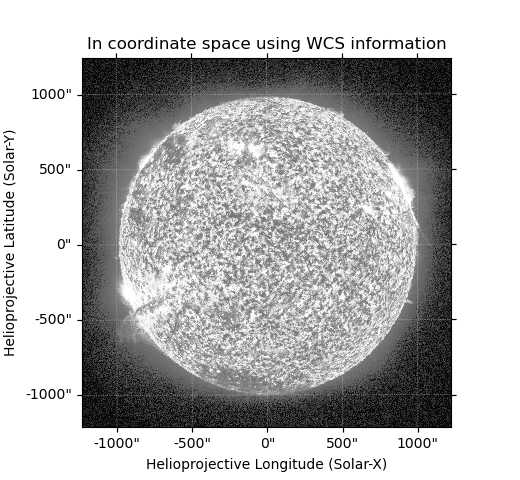
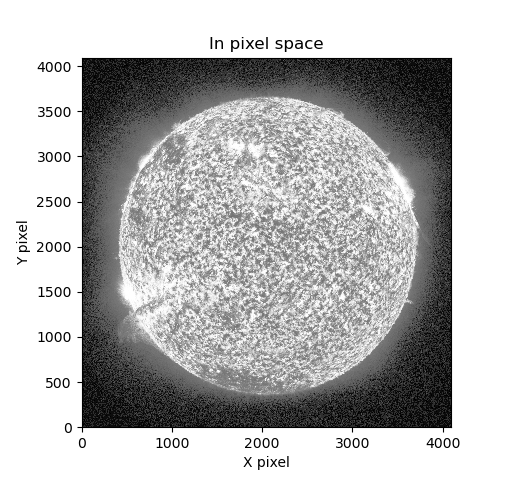
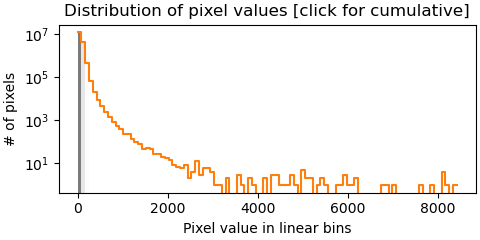
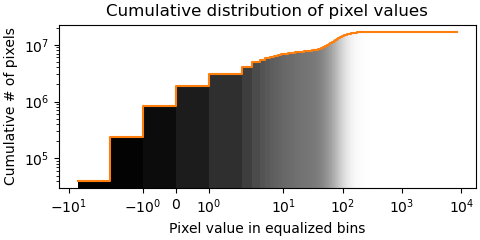

In [3]:
m_aia

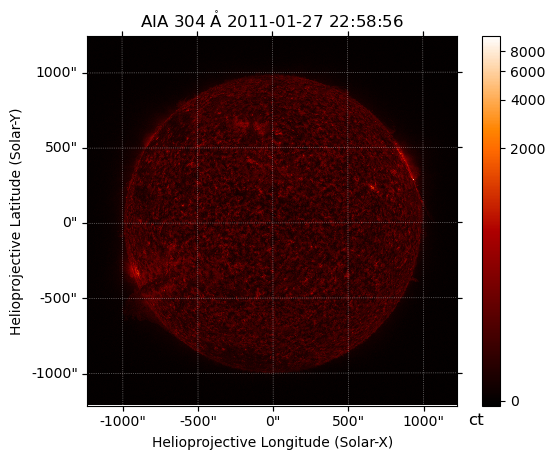

In [72]:
m_aia.peek()

In [4]:
image_data=m_aia.data
image_data

array([[ 0, -1,  0, ...,  0,  1,  0],
       [-1, -1,  1, ...,  2, -2,  1],
       [-1,  1,  3, ...,  0, -1,  2],
       ...,
       [ 1,  0, -2, ..., -2,  0, -1],
       [ 0,  0, -1, ..., -1, -1,  1],
       [ 0,  0,  1, ...,  0,  2,  0]], dtype=int16)

In [7]:
image_data[2048:,:].sum()

420143834

In [9]:
image_data[:2048,:].sum()

414040656

In [30]:
a=image_data<0
b=image_data<=0
c=image_data>150
d=image_data>1000

In [31]:
a_below_zero,=image_data[a].shape
b_below_zero,=image_data[b].shape
c_above,=image_data[c].shape
d_above,=image_data[d].shape

In [32]:
print("value < 0\t ratio:"+ "%.3f" %(a_below_zero/4096**2)+"\t sum:  "+str(np.sum(a*image_data)))

print("value <=0\t ratio:"+ "%.3f" %(b_below_zero/4096**2)+"\t sum:  "+str(np.sum(b*image_data)))

print("value>150\t ratio:"+ "%.3f" %(c_above/4096**2)+"\t sum: "+str(np.sum(c*image_data)))

print("value>1000\t ratio:"+ "%.5f" %(d_above/4096**2)+"\t sum: "+str(np.sum(d*image_data)))

print("total \t\t ratio:1 \t sum: "+str(np.sum(image_data)))

value < 0	 ratio:0.050	 sum:  -1127451
value <=0	 ratio:0.111	 sum:  -1127451
value>150	 ratio:0.042	 sum: 147062046
value>1000	 ratio:0.00007	 sum: 1809117
total 		 ratio:1 	 sum: 834184490


(array([ 4., 26.,  0., ...,  0.,  0.,  1.]),
 array([-7.00000000e+00, -6.38281993e+00, -5.76563986e+00, ...,
         8.42676564e+03,  8.42738282e+03,  8.42800000e+03]),
 <BarContainer object of 13667 artists>)

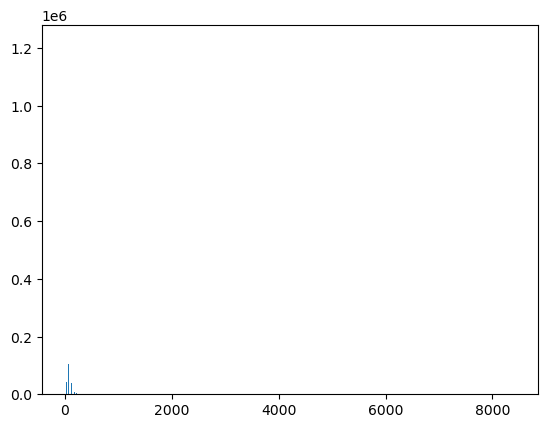

In [5]:
flat_data=image_data.flatten()
plt.hist(flat_data,bins='auto')

(array([4.000000e+00, 2.600000e+01, 0.000000e+00, 4.650000e+02,
        4.318000e+03, 0.000000e+00, 3.605900e+04, 0.000000e+00,
        1.971420e+05, 6.052090e+05, 0.000000e+00, 1.018582e+06,
        1.219953e+06, 0.000000e+00, 1.035096e+06, 0.000000e+00,
        8.097150e+05, 5.585440e+05, 0.000000e+00, 3.915380e+05,
        0.000000e+00, 2.847840e+05, 2.208840e+05, 0.000000e+00,
        1.795420e+05, 1.498390e+05, 0.000000e+00, 1.265210e+05,
        0.000000e+00, 1.102080e+05, 9.700000e+04, 0.000000e+00,
        8.593800e+04, 7.673600e+04, 0.000000e+00, 6.908100e+04,
        0.000000e+00, 6.287200e+04, 5.732000e+04, 0.000000e+00,
        5.280900e+04, 0.000000e+00, 4.821900e+04, 4.435500e+04,
        0.000000e+00, 4.137700e+04, 3.878800e+04, 0.000000e+00,
        3.625700e+04, 0.000000e+00, 3.458200e+04, 3.312100e+04,
        0.000000e+00, 3.220100e+04, 0.000000e+00, 3.154000e+04,
        3.201500e+04, 0.000000e+00, 3.266800e+04, 3.686300e+04,
        0.000000e+00, 4.236000e+04, 0.00

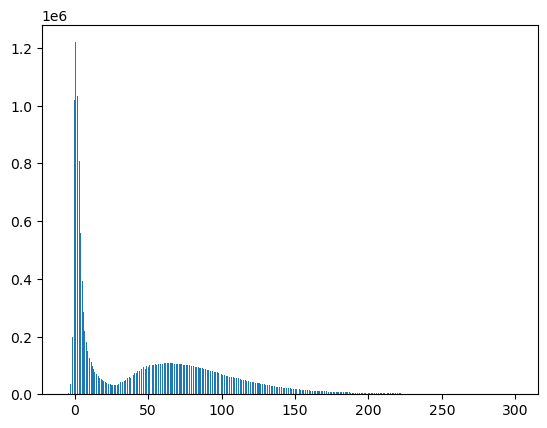

In [122]:
plt.hist(flat_data,bins='auto',range=(-7,300))

In [4]:
plt.hist(flat_data,bins='auto',range=(0,200))

NameError: name 'flat_data' is not defined

Min: -7
Max: 8428
Mean: 49.72127020359039
Stdev: 57.54598451095046


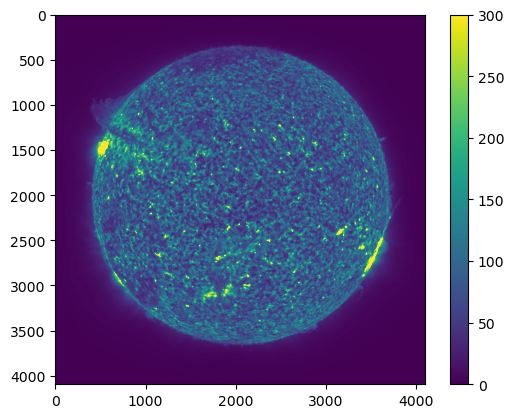

In [34]:
plt.imshow(m_aia.data,vmin=0,vmax=300)
plt.colorbar()
print('Min:', np.min(m_aia.data))
print('Max:', np.max(m_aia.data))
print('Mean:', np.mean(m_aia.data))
print('Stdev:', np.std(m_aia.data))

In [71]:
m_aia.unit 

Unit("ct")

## Bright part of the image

In [61]:
m_aia.mask

In [62]:
aiamap_mask.mask

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

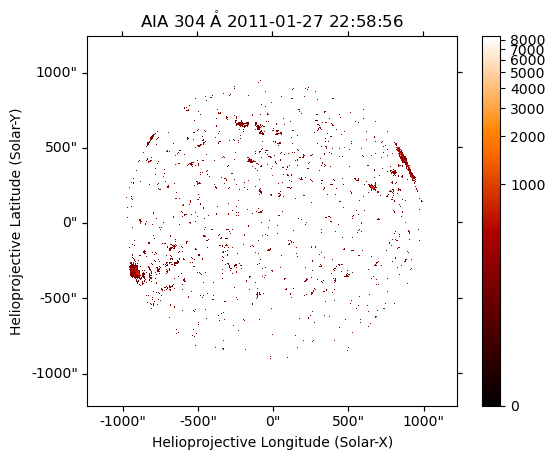

In [90]:
aiamap_masked=sunpy.map.Map(AIA_filename)
# mask_aia=sunpy.map.Map(AIA_filename)
mask=m_aia.data<200
aiamap_masked.mask=mask
# plt.figure()
aiamap_masked.plot()

# plt.show()
cbar = plt.colorbar()
cbar.solids.set_edgecolor("face")


array([[   0,    0],
       [   0,    2],
       [   0,    5],
       ...,
       [4095, 4091],
       [4095, 4093],
       [4095, 4095]], dtype=int64)

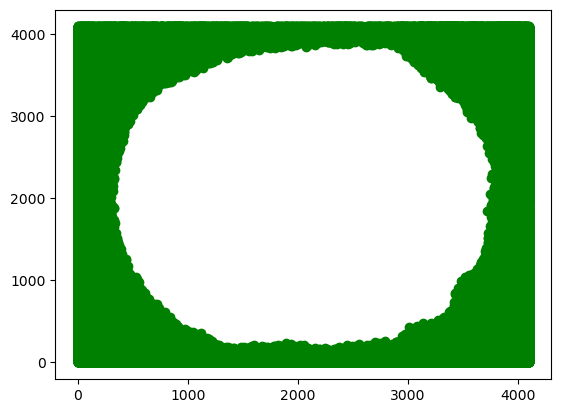

In [89]:
bright=np.argwhere(image_data==0)
plt.scatter(bright[:,0],bright[:,1],color="green")
ax=plt.gca()
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

bright


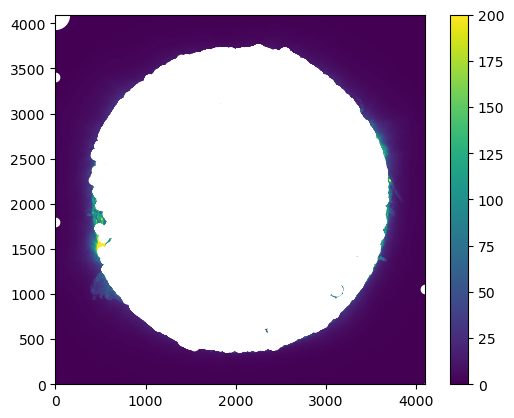

In [118]:
plt.imshow(image_data,vmin=0,vmax=200)
plt.colorbar()
plt.plot(0,4095,color='white', marker='o',markersize=20)
bright=np.argwhere((150<image_data)*(image_data<210))
ax=plt.scatter(bright[:,0],bright[:,1],color='white', marker='o')


ax=plt.gca()
ax.yaxis.set_ticks_position('left')
ax.invert_yaxis() 

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [95]:
bright

array([[   0, 4095],
       [2207, 1061],
       [2208, 1062],
       [2493, 3613],
       [2493, 3614],
       [2494, 3613],
       [2494, 3614],
       [2494, 3617],
       [2494, 3618],
       [2495, 3613],
       [2495, 3614],
       [2495, 3615],
       [2495, 3616],
       [2495, 3617],
       [2495, 3618],
       [2496, 3613],
       [2496, 3614],
       [2496, 3616],
       [2496, 3617],
       [2496, 3618],
       [2497, 3613],
       [2497, 3615],
       [2497, 3616],
       [2497, 3617],
       [2498, 3612],
       [2498, 3613],
       [2498, 3615],
       [2498, 3616],
       [2499, 3612],
       [2499, 3613],
       [2500, 3611],
       [2500, 3612],
       [2500, 3613],
       [2501, 3611]], dtype=int64)

In [32]:
image_data[:,0]

array([ 0, -1, -1, ...,  1,  0,  0], dtype=int16)

In [ ]:
image

In [33]:
image_data[0,:]

array([ 0, -1,  0, ...,  0,  1,  0], dtype=int16)

In [38]:
image_data[0][4095]=9999

## solar disk

In [4]:
hpc_coords = all_coordinates_from_map(m_aia)
mask_withcircle = coordinate_is_on_solar_disk(hpc_coords)

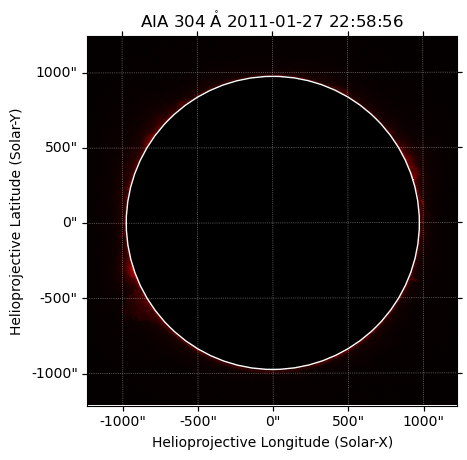

In [19]:
scaled_map = sunpy.map.Map(m_aia.data, m_aia.meta, mask=mask_withcircle)

palette = m_aia.cmap.copy()
palette.set_bad('black')

plt.figure()
scaled_map.plot(cmap=palette)
scaled_map.draw_limb()
plt.show()

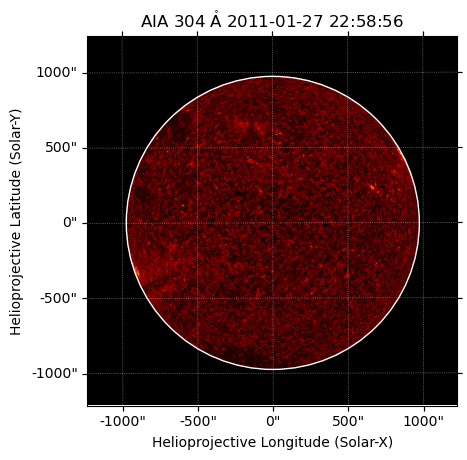

In [20]:
mask_outside_circle=1-mask_withcircle
scaled_map = sunpy.map.Map(m_aia.data, m_aia.meta, mask=mask_outside_circle)

palette = m_aia.cmap.copy()
palette.set_bad('black')

plt.figure()
scaled_map.plot(cmap=palette)
scaled_map.draw_limb()
plt.show()

In [12]:
hpc_coords?

Type:        SkyCoord
String form:
<SkyCoord (Helioprojective: obstime=2011-01-27T22:58:56.120, rsun=696000.0 km, observer=<Heliogra <...> 627,  1240.60998367), ( 1227.61445844,  1240.6085857 ),
           ( 1228.2146006 ,  1240.60718773)]]>
Length:      4096
File:        c:\users\asus-pc\anaconda3\envs\py_begin\lib\site-packages\astropy\coordinates\sky_coordinate.py
Docstring:  
High-level object providing a flexible interface for celestial coordinate
representation, manipulation, and transformation between systems.

The `SkyCoord` class accepts a wide variety of inputs for initialization. At
a minimum these must provide one or more celestial coordinate values with
unambiguous units.  Inputs may be scalars or lists/tuples/arrays, yielding
scalar or array coordinates (can be checked via ``SkyCoord.isscalar``).
Typically one also specifies the coordinate frame, though this is not
required. The general pattern for spherical representations is::

  SkyCoord(COORD, [FRAME], keyword_args ..

## world_to_pixel trial

In [26]:
point1 = m_aia.pixel_to_world(0 * u.pixel, 1000 * u.pixel)
string1=point1.to_string()
type(point1)

type(point1.frame)

sunpy.coordinates.frames.Helioprojective

In [ ]:
m_aia

In [29]:
point1

<SkyCoord (Helioprojective: obstime=2011-01-27T22:58:56.120, rsun=696000.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2011-01-27T22:58:56.120, rsun=696000.0 km): (lon, lat, radius) in (deg, deg, m)
    (-0.01420157, -5.68966161, 1.47297167e+11)>): (Tx, Ty) in arcsec
    (-1233.68584274, -611.21190193)>

In [15]:
m_aia.center

<SkyCoord (Helioprojective: obstime=2011-01-27T22:58:56.120, rsun=696000.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2011-01-27T22:58:56.120, rsun=696000.0 km): (lon, lat, radius) in (deg, deg, m)
    (-0.01420157, -5.68966161, 1.47297167e+11)>): (Tx, Ty) in arcsec
    (-3.42399969, 14.62804871)>

In [5]:
m_aia.world_to_pixel(m_aia.center)

PixelPair(x=<Quantity 2047.5 pix>, y=<Quantity 2047.5 pix>)

## adding up together each pixel

In [233]:
image_shape_x,image_shape_y=1000,1000

In [221]:
math.log10(sum(sum(image_data)))

7.224117526075401

In [231]:
image_data=m_aia.data
image_shape_x,image_shape_y=m_aia.data.shape

In [122]:
def wavelength_shift(Tx,Ty):
    return  0.0752 * Tx**2 + 0.265*Ty

In [207]:
def my_Gaussian1D(x,amplitude=1, mean=0, stddev=1):
    return amplitude*math.e**(-(x-mean)**2/(2*stddev**2))

In [232]:
start = time.time()

total_irradiance=0
g1 = Gaussian1D(1, 0, 0.2)
for pixel_x in range(0,image_shape_x):
    for pixel_y in range(0,image_shape_y):
        Tx,Ty=my_offaxis_angle_rad(pixel_x,pixel_y)
        
#         g1 = Gaussian1D(image_data[pixel_x][pixel_y], -wavelength_shift(Tx,Ty), 0.1*gaussian_fwhm_to_sigma)        
#         total_irradiance+=g1(0.1)
#         自己写的高斯函数比astropy   Gaussian1D 快得多

        stddev=0.1*gaussian_fwhm_to_sigma
        amplitude=image_data[pixel_x][pixel_y]/(math.sqrt(2*math.pi)*stddev)
        coeff=(amplitude,  #amplitude
               -wavelength_shift(Tx,Ty),      #mean
               stddev)    #stddev
        total_irradiance+=my_Gaussian1D(0.1,*coeff)
        
        
total_irradiance
end=time.time()
totaltime=end-start
totaltime

print("irridiance: "+str(total_irradiance))
print("time:"+str(totaltime))

irridiance: 489972427.5654012
time:108.52745699882507


In [223]:
# check my Gaussian is correct
coeff=(1,0,1)
num=10
x=np.linspace(0,2,num)
y0=np.zeros((num,))
y1=np.zeros((num,))
for i in range(num):
    x[i]
    y0[i]=Gaussian1D()(x[i])
    y1[i]=my_Gaussian1D(x[i],*coeff)
y0-y1

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -1.11022302e-16,  0.00000000e+00, -5.55111512e-17,
       -2.77555756e-17,  0.00000000e+00])

In [238]:
math.log10(489972427.5654012)

8.690171641471132

## My pixel to world
Obviously, it takes too much time.

Because I'll only use one picture, I can work out an expression of  pixel_to_world   using approximation. 

In [85]:
def offaxis_angle_rad(pixel_x,pixel_y):
    """
    """
    point = m_aia.pixel_to_world(pixel_x * u.pixel, pixel_y * u.pixel)
    ## this step takes up 80% of the time
    Tx,Ty=point.to_string().split()
    Tx,Ty=float(Tx),float(Ty) #degree
    Tx,Ty=Tx*math.pi/180,Ty*math.pi/180
    return Tx,Ty

## to get the coeff  using approximation 
(Tx,Ty)=f(x_pixel,y_pixel)
but I don't know how to use optimize.leastsq to get Tx,Ty approximazed one time

#### get the standard pixel_to_world transition

In [103]:
image_shape_x,image_shape_y=m_aia.data.shape
approximation_points_num=20
x_pixel_list=np.linspace(0,image_shape_x,approximation_points_num)
y_pixel_list=np.linspace(0,image_shape_y,approximation_points_num)
standard_Tx_list=np.zeros((approximation_points_num**2,1))
standard_Ty_list=np.zeros((approximation_points_num**2,1))

point_list=np.zeros((approximation_points_num**2, 2))
i=0

for x_pixel in x_pixel_list:
    for y_pixel in y_pixel_list:
        point_list[i]=x_pixel,y_pixel
        standard_Tx_list[i],standard_Ty_list[i]=offaxis_angle_rad(x_pixel,y_pixel)
        i+=1
        

#### approximation

In [55]:
def func_Tx(x, y, p):
    a,b,c=p
    return a*x+b*y+c

def func_Ty(x, y, p):
    a,b,c=p
    return a*x+b*y+c

In [56]:
def residuals_Tx(p, Tx, x , y ):
    """ 得到数据 z 和拟合函数之间的差
    """
    return Tx - func_Tx(x , y , p)

def residuals_Ty(p, Ty, x , y ):
    """ 得到数据 z 和拟合函数之间的差
    """
    return Ty - func_Ty(x , y , p)

In [66]:
x=point_list[:,0]
y=point_list[:,1]
Tx=standard_Tx_list
Tx=Tx.reshape(approximation_points_num**2,)
Ty=standard_Ty_list
Ty=Ty.reshape(approximation_points_num**2,)

plsq_Tx = optimize.leastsq(residuals_Tx, np.array([0, 0, 0]), args=(Tx, x , y ))  # 最小二乘法拟合
plsq_Ty = optimize.leastsq(residuals_Ty, np.array([0, 0, 0]), args=(Ty, x , y ))  # 最小二乘法拟合


In [67]:
plsq_Tx[0]

array([ 2.90965166e-06,  6.67361538e-09, -5.98777587e-03])

In [68]:
plsq_Ty[0]

array([-6.67397117e-09,  2.90963274e-06, -5.87289077e-03])

In [95]:
def my_offaxis_angle_rad(pixel_x,pixel_y):
    """
    """
    
    Tx=plsq_Tx[0][0]*pixel_x+plsq_Tx[0][1]*pixel_y+plsq_Tx[0][2]
    Ty=plsq_Ty[0][0]*pixel_x+plsq_Ty[0][1]*pixel_y+plsq_Ty[0][2]

    return Tx,Ty

### confirm approximation

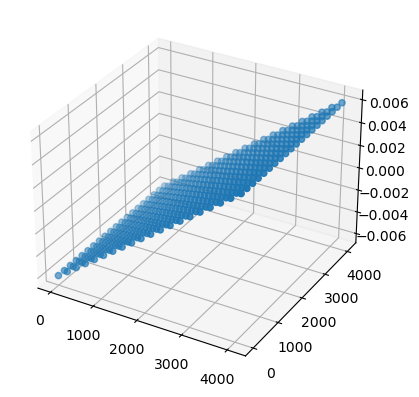

In [72]:
point_x_list=point_list[:,0]
point_y_list=point_list[:,1]
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.scatter(point_x_list, point_y_list, standard_Tx_list)

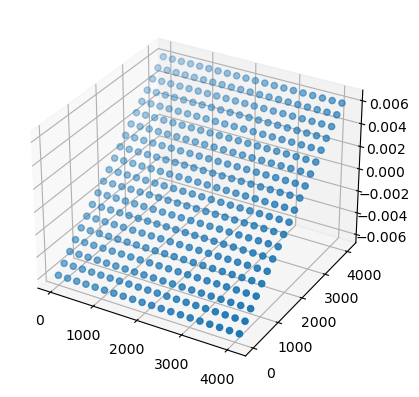

In [74]:
point_x_list=point_list[:,0]
point_y_list=point_list[:,1]
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.scatter(point_x_list, point_y_list, standard_Ty_list)

In [102]:
for i in range(0,4000,500):
    print(np.array(my_offaxis_angle_rad(i,i))-np.array(offaxis_angle_rad(i,i)))
    print(np.array(offaxis_angle_rad(i,i)))
    print()

[-2.24492965e-08 -8.47344984e-08]
[-0.00598775 -0.00587281]

[ 4.86408339e-09 -3.70226525e-09]
[-0.00452962 -0.00442141]

[1.47241708e-08 2.49700904e-08]
[-0.00307147 -0.00296996]

[1.06216241e-08 1.87358609e-08]
[-0.0016133  -0.00151847]

[1.28308973e-09 4.58859686e-10]
[-1.55126609e-04 -6.69736939e-05]

[-9.80077392e-09 -1.81672074e-08]
[0.00130305 0.00138452]

[-1.56486498e-08 -1.74201198e-08]
[0.00276122 0.002836  ]

[-5.78856243e-09 -6.20105674e-09]
[0.00421937 0.00428747]



#### learn to use optimize.leastsq

In [181]:
def func_Tx(x_pixel, y_pixel, p):
    a,b=p
    return a*x_pixel+b*y_pixel

def func_Ty(x_pixel, y_pixel, p):
    a,b=p
    return a*x_pixel+b*y_pixel

In [182]:
def residuals(p, z, x_pixel, y_pixel):
    """ 得到数据 z 和拟合函数之间的差
    """
    print(p)
    print(Tx - func_Tx(x_pixel, y_pixel, p))
    print()
    return Tx - func_Tx(x_pixel, y_pixel, p)

In [183]:
x_pixel = np.arange(5)
y_pixel = np.linspace(100,0,5)
Tx = np.array([2, 4, 6, 9, 100])  # 数据随便取的
plsq = optimize.leastsq(residuals, np.array([0, 0]), args=(Tx, x_pixel, y_pixel))  # 最小二乘法拟合

[0 0]
[  2.   4.   6.   9. 100.]

[0. 0.]
[  2.   4.   6.   9. 100.]

[0. 0.]
[  2.   4.   6.   9. 100.]

[1.49011612e-08 0.00000000e+00]
[ 2.          3.99999999  5.99999997  8.99999996 99.99999994]

[0.00000000e+00 1.49011612e-08]
[  1.99999851   3.99999888   5.99999925   8.99999963 100.        ]

[16.1  -0.16]
[ 18.   -0.1 -18.2 -35.3  35.6]

[16.10000024 -0.16      ]
[ 18.          -0.10000024 -18.20000048 -35.30000072  35.59999904]

[16.1  -0.16]
[ 17.99999976  -0.10000018 -18.20000012 -35.30000006  35.6       ]

[16.10000004 -0.16      ]
[ 18.00000005  -0.1        -18.20000005 -35.3000001   35.59999984]



In [82]:
plsq[0]

array([16.1 , -0.16])

## coordinate

In [25]:
coord = SkyCoord(70*u.deg, -30*u.deg, obstime="2017-08-01",
                 frame=frames.HeliographicStonyhurst)
coord

<SkyCoord (HeliographicStonyhurst: obstime=2017-08-01T00:00:00.000, rsun=695700.0 km): (lon, lat) in deg
    (70., -30.)>

In [27]:
SkyCoord?

Init signature: SkyCoord(*args, copy=True, **kwargs)
Docstring:     
High-level object providing a flexible interface for celestial coordinate
representation, manipulation, and transformation between systems.

The `SkyCoord` class accepts a wide variety of inputs for initialization. At
a minimum these must provide one or more celestial coordinate values with
unambiguous units.  Inputs may be scalars or lists/tuples/arrays, yielding
scalar or array coordinates (can be checked via ``SkyCoord.isscalar``).
Typically one also specifies the coordinate frame, though this is not
required. The general pattern for spherical representations is::

  SkyCoord(COORD, [FRAME], keyword_args ...)
  SkyCoord(LON, LAT, [FRAME], keyword_args ...)
  SkyCoord(LON, LAT, [DISTANCE], frame=FRAME, unit=UNIT, keyword_args ...)
  SkyCoord([FRAME], <lon_attr>=LON, <lat_attr>=LAT, keyword_args ...)

It is also possible to input coordinate values in other representations
such as cartesian or cylindrical.  In this ca

# Analysis using astropy

In [ ]:
AIA_file_name="data/AIA/aia_lev1_304a_2011_01_27t22_58_56_12z_image_lev1.fits"
hdulist=fits.open(AIA_file_name)
image_data=hdulist[1].data

## hdulist[0]: astropy.io.fits.hdu.image.PrimaryHDU

In [20]:
hdulist?

Type:           HDUList
String form:    [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x00000152240B6790>, <astropy.io.fits.hdu.compressed.CompImageHDU object at 0x00000152240B69A0>]
Length:         2
File:           c:\users\asus-pc\anaconda3\envs\py_begin\lib\site-packages\astropy\io\fits\hdu\hdulist.py
Docstring:     
HDU list class.  This is the top-level FITS object.  When a FITS
file is opened, a `HDUList` object is returned.
Init docstring:
Construct a `HDUList` object.

Parameters
----------
hdus : BaseHDU or sequence thereof, optional
    The HDU object(s) to comprise the `HDUList`.  Should be
    instances of HDU classes like `ImageHDU` or `BinTableHDU`.

file : file-like, bytes, optional
    The opened physical file associated with the `HDUList`
    or a bytes object containing the contents of the FITS
    file.


In [74]:
type(hdulist[0])

astropy.io.fits.hdu.image.PrimaryHDU

In [75]:
astropy.io.fits.hdu.image.PrimaryHDU?

Init signature:
astropy.io.fits.hdu.image.PrimaryHDU(
    data=None,
    header=None,
    do_not_scale_image_data=False,
    ignore_blank=False,
    uint=True,
    scale_back=None,
)
Docstring:      FITS primary HDU class.
Init docstring:
Construct a primary HDU.

Parameters
----------
data : array or ``astropy.io.fits.hdu.base.DELAYED``, optional
    The data in the HDU.

header : `~astropy.io.fits.Header`, optional
    The header to be used (as a template).  If ``header`` is `None`, a
    minimal header will be provided.

do_not_scale_image_data : bool, optional
    If `True`, image data is not scaled using BSCALE/BZERO values
    when read. (default: False)

ignore_blank : bool, optional
    If `True`, the BLANK header keyword will be ignored if present.
    Otherwise, pixels equal to this value will be replaced with
    NaNs. (default: False)

uint : bool, optional
    Interpret signed integer data where ``BZERO`` is the
    central value and ``BSCALE == 1`` as unsigned integer
   

In [65]:
hdulist[0].data

In [68]:
hdulist[0].header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                   16 / number of bits per data pixel                  
NAXIS   =                    0 / number of data axes                            
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 

## hdulist[1]: astropy.io.fits.hdu.compressed.CompImageHDU

In [76]:
type(hdulist[1])

astropy.io.fits.hdu.compressed.CompImageHDU

In [77]:
astropy.io.fits.hdu.compressed.CompImageHDU?

Init signature:
astropy.io.fits.hdu.compressed.CompImageHDU(
    data=None,
    header=None,
    name=None,
    compression_type='RICE_1',
    tile_size=None,
    hcomp_scale=0,
    hcomp_smooth=0,
    quantize_level=16.0,
    quantize_method=-1,
    dither_seed=0,
    do_not_scale_image_data=False,
    uint=False,
    scale_back=False,
    **kwargs,
)
Docstring:      Compressed Image HDU class.
Init docstring:
Parameters
----------
data : array, optional
    Uncompressed image data

header : `~astropy.io.fits.Header`, optional
    Header to be associated with the image; when reading the HDU from a
    file (data=DELAYED), the header read from the file

name : str, optional
    The ``EXTNAME`` value; if this value is `None`, then the name from
    the input image header will be used; if there is no name in the
    input image header then the default name ``COMPRESSED_IMAGE`` is
    used.

compression_type : str, optional
    Compression algorithm: one of
    ``'RICE_1'``, ``'RICE_ONE'`

In [28]:
hdulist[1].compression_type

AttributeError: 'CompImageHDU' object has no attribute 'compression_type'

In [29]:
hdulist[1].data

array([[ 0, -1,  0, ...,  0,  1,  0],
       [-1, -1,  1, ...,  2, -2,  1],
       [-1,  1,  3, ...,  0, -1,  2],
       ...,
       [ 1,  0, -2, ..., -2,  0, -1],
       [ 0,  0, -1, ..., -1, -1,  1],
       [ 0,  0,  1, ...,  0,  2,  0]], dtype=int16)

In [6]:
image_data

array([[ 0, -1,  0, ...,  0,  1,  0],
       [-1, -1,  1, ...,  2, -2,  1],
       [-1,  1,  3, ...,  0, -1,  2],
       ...,
       [ 1,  0, -2, ..., -2,  0, -1],
       [ 0,  0, -1, ..., -1, -1,  1],
       [ 0,  0,  1, ...,  0,  2,  0]], dtype=int16)

In [7]:
image_data.shape

(4096, 4096)

In [82]:
print('Min:', np.min(image_data))
print('Max:', np.max(image_data))
print('Mean:', np.mean(image_data))
print('Stdev:', np.std(image_data))

Min: -7
Max: 8428
Mean: 49.72127020359039
Stdev: 57.54598451095046


In [8]:
flat_data=image_data.flatten()

(array([ 4., 26.,  0., ...,  0.,  0.,  1.]),
 array([-7.00000000e+00, -6.38281993e+00, -5.76563986e+00, ...,
         8.42676564e+03,  8.42738282e+03,  8.42800000e+03]),
 <BarContainer object of 13667 artists>)

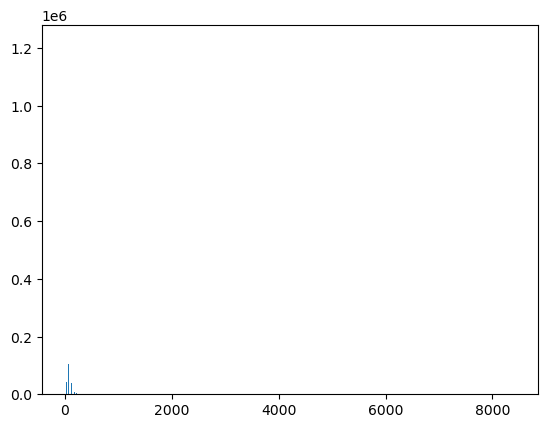

In [52]:
flat_data=image_data.flatten()
plt.hist(flat_data,bins='auto')

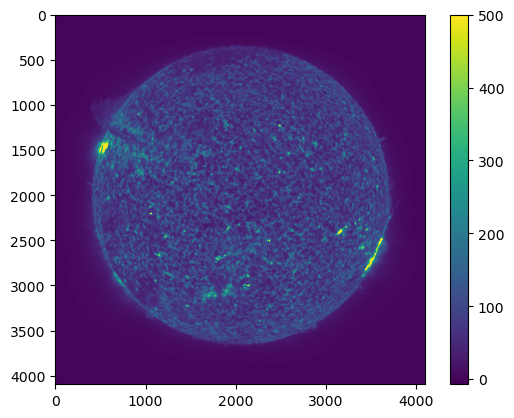

In [6]:
plt.imshow(image_data,vmin=-7,vmax=500)
plt.colorbar()

In [17]:
type(image_data.argmax(axis=None))
image_data.argmax(axis=0)

array([3070, 2570, 2569, ..., 3158, 3157, 1753], dtype=int64)

## Gaussian profile

### failed attempt
时间太长
adding up 4096^2 Gaussian profile leads to a dead kernel

    Windows fatal exception: stack overflow

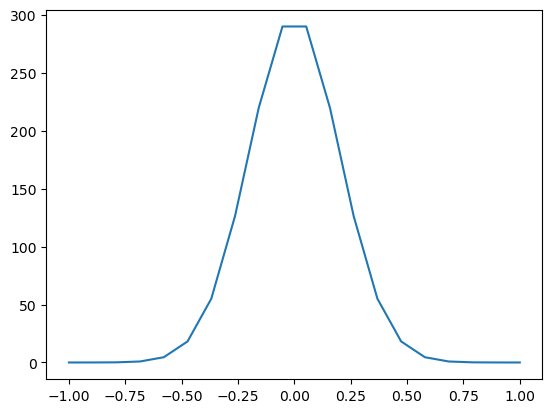

In [2]:
g1 = Gaussian1D(1, 0, 0.2)
g2=g1-g1
for i in range(300):
    g2+=g1
x = np.linspace(-1, 1, 20)
plt.plot(x,g2(x))

In [6]:
g2?

Signature:      g2(*args, **kwargs)
Type:           CompoundModel
String form:   
Model: CompoundModel
           Inputs: ('x',)
           Outputs: ('y',)
           Model set size: 1
           Expression: [0] - [1] + [2] <...> ---- ----------
           1.0    0.0      0.2         1.0 ...           1.0      0.0        0.2
Length:         1
File:           c:\users\asus-pc\anaconda3\envs\py_begin\lib\site-packages\astropy\modeling\core.py
Docstring:     
Base class for compound models.

While it can be used directly, the recommended way
to combine models is through the model operators.
Call docstring:
Evaluate this model using the given input(s) and the parameter values
that were specified when the model was instantiated.


In [22]:
compoundModel?

Object `compoundModel` not found.


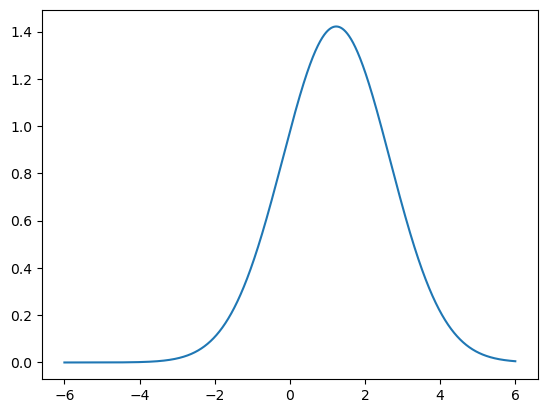

In [17]:
x=np.linspace(-6,6,1000000)
plt.plot(x,Gaussian1D(1.42134,1.234,1.42398423)(x))

### Alternative method
just to give out the value of "compoundmodel" at several points

In [11]:
x = np.linspace(-1, 1, 20)

for i in image_data[0,:4000]:
    y=Gaussian1D(math.sin(i),0,1)(x)
y

array([-0.55151677, -0.60935147, -0.66583234, -0.71953144, -0.76899327,
       -0.81279902, -0.84963361, -0.87835093, -0.89803305, -0.90803888,
       -0.90803888, -0.89803305, -0.87835093, -0.84963361, -0.81279902,
       -0.76899327, -0.71953144, -0.66583234, -0.60935147, -0.55151677])

SyntaxError: invalid syntax (1901293375.py, line 1)

In [20]:
y=Gaussian1D(1,0,1)(x)
y

array([0.60653066, 0.67013439, 0.73224923, 0.79130482, 0.84570048,
       0.89387587, 0.9343847 , 0.96596658, 0.987612  , 0.99861592,
       0.99861592, 0.987612  , 0.96596658, 0.9343847 , 0.89387587,
       0.84570048, 0.79130482, 0.73224923, 0.67013439, 0.60653066])

Init signature: Gaussian1D(amplitude=1, mean=0, stddev=1, **kwargs)
Docstring:     
One dimensional Gaussian model.

Parameters
----------
amplitude : float or `~astropy.units.Quantity`.
    Amplitude (peak value) of the Gaussian - for a normalized profile
    (integrating to 1), set amplitude = 1 / (stddev * np.sqrt(2 * np.pi))
mean : float or `~astropy.units.Quantity`.
    Mean of the Gaussian.
stddev : float or `~astropy.units.Quantity`.
    Standard deviation of the Gaussian with FWHM = 2 * stddev * np.sqrt(2 * np.log(2)).

Notes
-----
Either all or none of input ``x``, ``mean`` and ``stddev`` must be provided
consistently with compatible units or as unitless numbers.

Model formula:

    .. math:: f(x) = A e^{- \frac{\left(x - x_{0}\right)^{2}}{2 \sigma^{2}}}

Examples
--------
>>> from astropy.modeling import models
>>> def tie_center(model):
...         mean = 50 * model.stddev
...         return mean
>>> tied_parameters = {'mean': tie_center}

Specify that 'mean' is a tied para

In [21]:
image_data[0,:20]

array([ 0, -1,  0, -1,  1,  0, -2,  0, -1,  0, -1,  0,  2,  3, -2,  0,  2,
       -3, -1,  0], dtype=int16)

In [3]:
g1 = Gaussian1D(1, 0, 0.2)
x = np.linspace(-1, 1, 20)
g2=g1-g1

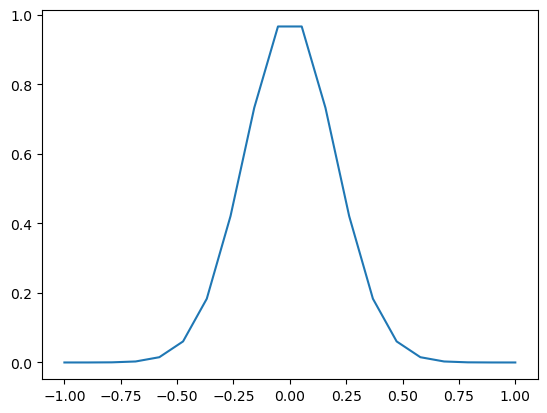

In [4]:
plt.plot(x,g1(x))

In [22]:
g1?

Signature:     
g1(
    *inputs,
    model_set_axis=None,
    with_bounding_box=False,
    fill_value=nan,
    equivalencies=None,
    inputs_map=None,
    **new_inputs,
)
Type:           Gaussian1D
String form:   
Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
    amplitude mean stddev
    --------- ---- ------
          1.0  0.0    0.2
Length:         1
File:           c:\users\asus-pc\anaconda3\envs\py_begin\lib\site-packages\astropy\modeling\functional_models.py
Docstring:     
One dimensional Gaussian model.

Parameters
----------
amplitude : float or `~astropy.units.Quantity`.
    Amplitude (peak value) of the Gaussian - for a normalized profile
    (integrating to 1), set amplitude = 1 / (stddev * np.sqrt(2 * np.pi))
mean : float or `~astropy.units.Quantity`.
    Mean of the Gaussian.
stddev : float or `~astropy.units.Quantity`.
    Standard deviation of the Gaussian with FWHM = 2 * stddev * np.sqrt(2 * np.log(2)).

Notes
-----
Either all or none 

# rough draft

[0 0 0]
[0. 0. 0.]
[0. 0. 0.]
[1.49011612e-08 0.00000000e+00 0.00000000e+00]
[0.00000000e+00 1.49011612e-08 0.00000000e+00]
[0.00000000e+00 0.00000000e+00 1.49011612e-08]
[-0.40322581  3.97741935  0.        ]
[-0.4032258   3.97741935  0.        ]
[-0.40322581  3.97741941  0.        ]
[-4.03225806e-01  3.97741935e+00  1.49011612e-08]
[-0.40322583  9.93366638 -5.95624696]
[-0.40322582  6.95554281 -2.97812342]
[-0.40322581  5.46648102 -1.48906166]
拟合结果:
a = -0.40322580645249223
b = 3.9774193548473846
c = 0.0


C:\Users\asus-pc\AppData\Local\Temp\ipykernel_18056\1314271252.py:47: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)    # 3D 绘图


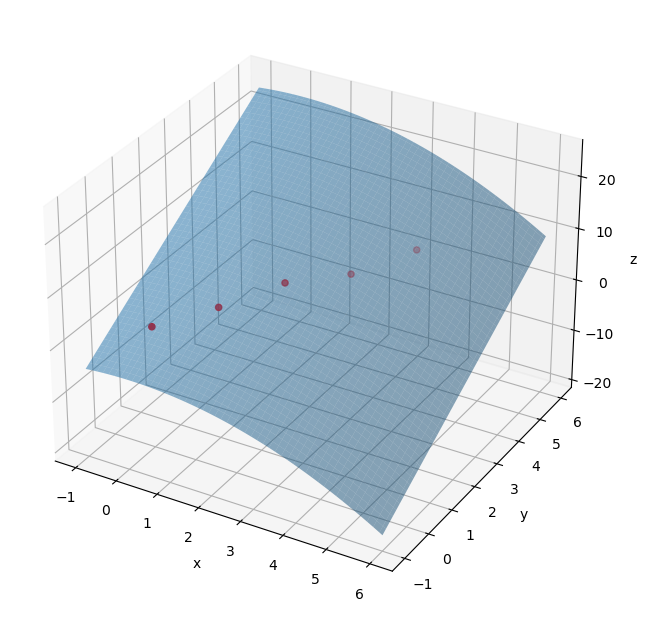

In [122]:
#https://blog.csdn.net/yuanboshuai/article/details/107490177

import numpy as np
from scipy import optimize		# 最小二乘法拟合
import matplotlib.pyplot as plt 	# python matplotlib 绘图
from mpl_toolkits.mplot3d import Axes3D  # 3D 绘图
 
 
def func(x, y, p):
	""" 数据拟合所用的函数：z=ax+by
	:param x: 自变量 x
	:param y: 自变量 y
	:param p: 拟合参数 a, b
	"""
	a, b, c = p
	return a * x**2 + b * y +c*x
 
 
def residuals(p, z, x, y):
	""" 得到数据 z 和拟合函数之间的差
	"""
	print(p)
	return z - func(x, y, p)
 
 
def main():
	x = np.arange(5)
	y = np.arange(5)
	z = np.array([2, 4, 7, 7, 10])  # 数据随便取的
 
	plsq = optimize.leastsq(residuals, np.array([0, 0, 0]), args=(z, x, y))  # 最小二乘法拟合
	# [0, 0] 为参数 a, b 初始值
 
	a, b, c= plsq[0]  # 获得拟合结果
	print("拟合结果:\na = {}".format(a))
	print("b = {}".format(b))
	print("c = {}".format(c))
 
	# 绘图
	xp = np.linspace(-1, 6, 100)
	yp = np.linspace(-1, 6, 100)
 
	X, Y = np.meshgrid(xp, yp)
	Z = func(X, Y, [a, b, c])   # 带入拟合得到的 a, b, c 
 
	fig = plt.figure(figsize=(8, 6))
	ax = Axes3D(fig)    # 3D 绘图
 
	ax.plot_surface(X, Y, Z, alpha=0.5)
	ax.scatter(x, y, z, color="r")
 
	ax.set_xlabel("x")
	ax.set_ylabel("y")
	ax.set_zlabel("z")
 
	plt.show()
    
main()

In [17]:
b=a.reshape(3,4)
b

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11]])

In [38]:
import numpy as np
import matplotlib.pyplot as plt
x = [10,20,30,40,50,60,70,80]
x = np.array(x)
print('x is :\n',x)
num = [174,236,305,334,349,351,342,323]
y = np.array(num)
print('y is :\n',y)
# f1 为各项的系数，3 表示想要拟合的最高次项是多少。
f1 = np.polyfit(x, y, 3)
# p1 为拟合的多项式表达式
p1 = np.poly1d(f1)
print('p1 is :\n',p1)

# plt.plot(x, y, 's',label='original values')
# yvals = p1(x) #拟合y值
# plt.plot(x, yvals, 'r',label='polyfit values')

x is :
 [10 20 30 40 50 60 70 80]
y is :
 [174 236 305 334 349 351 342 323]
p1 is :
            3          2
0.0003687 x - 0.1287 x + 11.06 x + 72.64


In [41]:
p1

poly1d([ 3.68686869e-04, -1.28701299e-01,  1.10570707e+01,  7.26428571e+01])

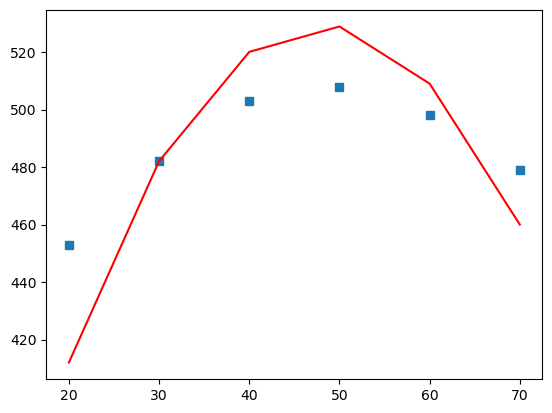

In [42]:
from scipy.optimize import curve_fit
x = [20,30,40,50,60,70]
x = np.array(x)
num = [453,482,503,508,498,479]
y = np.array(num)

# 这里的函数可以自定义任意形式。
def func(x, a, b,c):
    return a*np.sqrt(x)*(b*np.square(x)+c)

# popt返回的是给定模型的最优参数。我们可以使用pcov的值检测拟合的质量，其对角线元素值代表着每个参数的方差。
popt, pcov = curve_fit(func, x, y)
a = popt[0] 
b = popt[1]
c = popt[2]
yvals = func(x,a,b,c) #拟合y值
plot1 = plt.plot(x, y, 's',label='original values')
plot2 = plt.plot(x, yvals, 'r',label='polyfit values')

In [43]:
popt

array([-1.96401671e-01,  4.20401375e-02, -4.85953552e+02])

In [67]:
import numpy as np
from scipy import optimize		# 最小二乘法拟合
import matplotlib.pyplot as plt 	# python matplotlib 绘图
from mpl_toolkits.mplot3d import Axes3D  # 3D 绘图
 
 
def func(x, y, p):
	""" 数据拟合所用的函数：z=ax+by
	:param x: 自变量 x
	:param y: 自变量 y
	:param p: 拟合参数 a, b
	"""
	a, b, c = p
	return np.array([ b * y , a*x]).T
 
 
def residuals(p, z, x, y):
    """ 得到数据 z 和拟合函数之间的差
    """
    # print("z")
    # print(z.shape)
    # print('func')
    # print(func(x,y,p).shape)
    print(z - func(x, y, p))
    return z - func(x, y, p)
 
 
def main():
	x = np.arange(5)
	y = np.arange(5)
	z = np.array([[0,0], [1,1], [2,2],[3,3],[4,4]])  # 数据随便取的
 
	plsq = optimize.leastsq(residuals, np.array([0, 0, 0]), args=(z, x, y))  # 最小二乘法拟合
	# [0, 0] 为参数 a, b 初始值
 
	a, b, c= plsq[0]  # 获得拟合结果
	print("拟合结果:\na = {}".format(a))
	print("b = {}".format(b))
	print("c = {}".format(c))
 


# 	# 绘图
# 	xp = np.linspace(-1, 6, 100)
# 	yp = np.linspace(-1, 6, 100)
 
# 	X, Y = np.meshgrid(xp, yp)
# 	Z = func(X, Y, [a, b, c])   # 带入拟合得到的 a, b, c 
 
# 	fig = plt.figure(figsize=(8, 6))
# 	ax = Axes3D(fig)    # 3D 绘图
 
# 	ax.plot_surface(X, Y, Z, alpha=0.5)
# 	ax.scatter(x, y, z, color="r")
 
# 	ax.set_xlabel("x")
# 	ax.set_ylabel("y")
# 	ax.set_zlabel("z")
 
# 	plt.show()
    
main()

[[0 0]
 [1 1]
 [2 2]
 [3 3]
 [4 4]]
[[0. 0.]
 [1. 1.]
 [2. 2.]
 [3. 3.]
 [4. 4.]]


ValueError: object too deep for desired array

error: Result from function call is not a proper array of floats.

In [56]:
np.array([1,2,4])

array([1, 2, 4])